## UTS

### Klasifikasi Berita Dengan Extraksi Fitur Model Topik Modelling Dengan Classifier Naïve Bayes dan SVM

#### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
import re

#### Fungsi Pembersihan Teks

In [2]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [w for w in text.split() if len(w) > 2]
    return ' '.join(words)

### Klasifikasi Berita

#### Load Data Berita

In [3]:
print("=== Memuat data berita ===")
berita = pd.read_csv("Data/Berita.csv")
print(berita.head())

=== Memuat data berita ===
   No                                              judul  \
0   1  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...   
1   2  PT SIER Beri Penghargaan untuk 50 Tenant Terba...   
2   3  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...   
3   4  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...   
4   5  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...   

                                              berita  \
0  Menteri Koordinator (Menko) Bidang Perekonomia...   
1  Dalam rangka memeriahkan hari jadi ke-50, PT S...   
2  Wacana Presiden Prabowo Subianto akan membentu...   
3  BPJS Ketenagakerjaan dan Kementerian Agama (Ke...   
4  Pemerintah akan segera membentuk Satuan Tugas ...   

                         tanggal kategori  \
0  Minggu, 01 Des 2024 23:40 WIB  Ekonomi   
1  Minggu, 01 Des 2024 20:45 WIB  Ekonomi   
2  Minggu, 01 Des 2024 19:40 WIB  Ekonomi   
3  Minggu, 01 Des 2024 19:03 WIB  Ekonomi   
4  Minggu, 01 Des 2024 19:00 WIB  Ekonomi   

    

#### Pembersihan Teks Berita

In [4]:
import re
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [w for w in text.split() if len(w) > 2]
    return ' '.join(words)

berita['clean_text'] = berita['berita'].apply(clean_text)

print("Kolom tersedia:", berita.columns.tolist())
print("Jumlah data:", len(berita))


Kolom tersedia: ['No', 'judul', 'berita', 'tanggal', 'kategori', 'link', 'clean_text']
Jumlah data: 1500


#### Ekstraksi Fitur dengan Topic Modeling (LDA)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

cv = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = cv.fit_transform(berita['clean_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)


,n_components,5
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [10]:
# --- Distribusi proporsi topik di setiap dokumen ---
topic_distribution = lda.transform(dtm)

# Jadikan DataFrame agar mudah dibaca
import pandas as pd
topic_df = pd.DataFrame(
    topic_distribution,
    columns=[f"Topik_{i+1}" for i in range(lda.n_components)]
)

# Gabungkan dengan data asli (opsional)
berita_topics = pd.concat([berita[['judul', 'kategori']], topic_df], axis=1)

print(berita_topics.head(10).to_markdown(index=False))

| judul                                                                 | kategori   |     Topik_1 |     Topik_2 |     Topik_3 |     Topik_4 |   Topik_5 |
|:----------------------------------------------------------------------|:-----------|------------:|------------:|------------:|------------:|----------:|
| Airlangga Harap Kenaikan UMP Tingkatkan Daya Beli Masyarakat Menengah | Ekonomi    | 0.000576931 | 0.000578952 | 0.000579232 | 0.000573979 |  0.997691 |
| PT SIER Beri Penghargaan untuk 50 Tenant Terbaik di HUT ke-50         | Ekonomi    | 0.00054047  | 0.112989    | 0.00054009  | 0.000543238 |  0.885387 |
| Prabowo Bakal Bentuk Kementerian Penerimaan Negara, Dipimpin Anggito  | Ekonomi    | 0.000677761 | 0.000671961 | 0.000673431 | 0.000671798 |  0.997305 |
| Sinergi Kemenag & BPJS Ketenagakerjaan Lindungi 165 Ribu GTK Madrasah | Ekonomi    | 0.000895337 | 0.156106    | 0.000888596 | 0.000876264 |  0.841234 |
| Pemerintah Segera Bentuk Satgas PHK Usai Tetapkan UMP Naik 6,5 Perse

#### Ekstraksi Fitur tambahan dengan TF-IDF (untuk classifier)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(berita['clean_text'])
y = berita['kategori']


#### Split Data untuk Training dan Testing

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Klasifikasi dengan Naïve Bayes dan SVM

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Naïve Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# SVM
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


#### Evaluasi Model

In [14]:
print("=== Hasil Klasifikasi Naïve Bayes ===")
print(classification_report(y_test, y_pred_nb))

print("\n=== Hasil Klasifikasi SVM ===")
print(classification_report(y_test, y_pred_svm))


=== Hasil Klasifikasi Naïve Bayes ===
               precision    recall  f1-score   support

      Ekonomi       0.91      0.96      0.93        73
Internasional       0.95      0.98      0.96        84
     Nasional       0.97      0.90      0.93        70
     Olahraga       1.00      0.99      0.99        73

     accuracy                           0.96       300
    macro avg       0.96      0.96      0.96       300
 weighted avg       0.96      0.96      0.96       300


=== Hasil Klasifikasi SVM ===
               precision    recall  f1-score   support

      Ekonomi       0.96      0.92      0.94        73
Internasional       0.94      0.96      0.95        84
     Nasional       0.92      0.94      0.93        70
     Olahraga       1.00      0.99      0.99        73

     accuracy                           0.95       300
    macro avg       0.95      0.95      0.95       300
 weighted avg       0.95      0.95      0.95       300



#### Visualisasi Sebaran Topik (X–Y Scatter Plot)

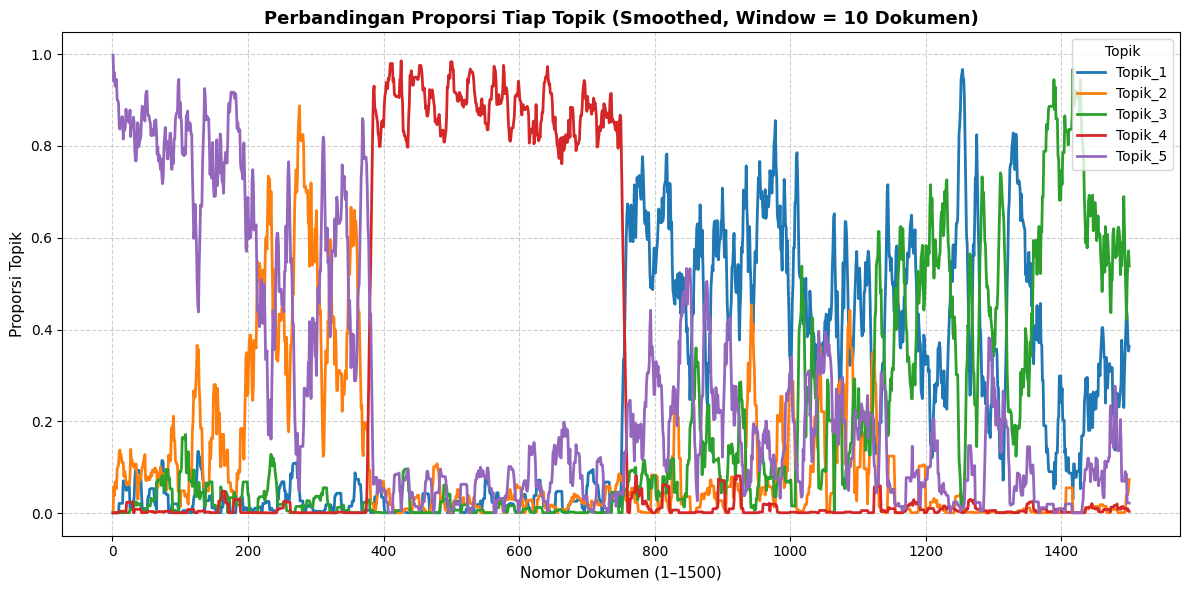

In [17]:
import matplotlib.pyplot as plt

# Ambil hanya kolom proporsi topik
topik_cols = [f"Topik_{i+1}" for i in range(5)]
topik_data = berita_topics[topik_cols]

# Hitung rata-rata bergerak (rolling mean) untuk menghaluskan grafik
# Window=10 artinya rata-rata dari 10 dokumen berurutan
topik_data_smooth = topik_data.rolling(window=10, min_periods=1).mean()

# Plot line chart
plt.figure(figsize=(12,6))
for col in topik_cols:
    plt.plot(
        range(1, len(topik_data_smooth)+1),
        topik_data_smooth[col],
        label=col,
        linewidth=2.0
    )

# Pengaturan visualisasi
plt.title("Perbandingan Proporsi Tiap Topik (Smoothed, Window = 10 Dokumen)", fontsize=13, fontweight='bold')
plt.xlabel("Nomor Dokumen (1–1500)", fontsize=11)
plt.ylabel("Proporsi Topik", fontsize=11)
plt.legend(title="Topik", loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Analisa Clutering Dokumen Pada Data Email 

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


📊 Jumlah data: 5572
   id                                               Text Unnamed: 2  \
0   1  Go until jurong point, crazy.. Available only ...        NaN   
1   2                      Ok lar... Joking wif u oni...        NaN   
2   3  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   4  U dun say so early hor... U c already then say...        NaN   
4   5  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

✅ Contoh hasil preprocessing:
   id                                         clean_text
0   1  go jurong point crazi avail bugi n great world...
1   2                              ok lar joke wif u oni
2   3  free entri wkli comp win fa cup final tkt st m...
3   4                u dun say earli hor u c alreadi say
4   5          nah dont think goe usf live around though

   id  abiola  abl  abt

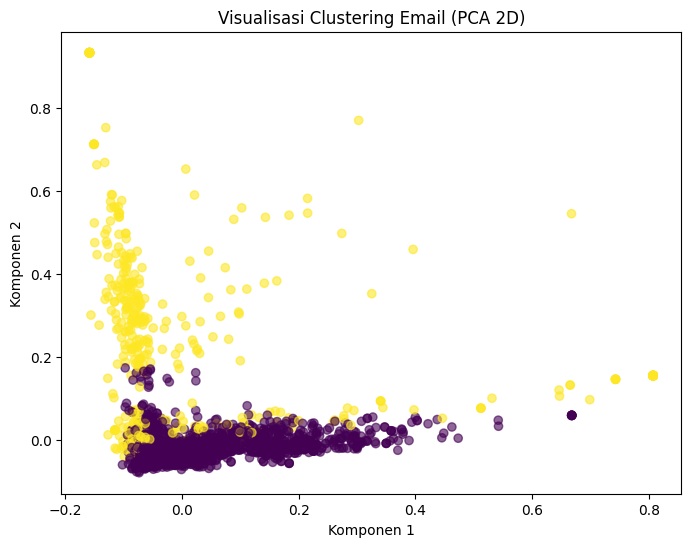


Contoh isi Cluster 0
1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat......

2. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's...

3. U dun say so early hor... U c already then say......


Contoh isi Cluster 1
1. Ok lar... Joking wif u oni......

2. Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?...

3. Yup... Ok i go home look at the timings then i msg Ì_ again... Xuhui going to learn on 2nd may too but her lesson is at 8am...



In [21]:
# Import library
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

#  Load data
df = pd.read_csv("Data/spam.csv", encoding='latin-1')
print("📊 Jumlah data:", len(df))
print(df.head())

# Pastikan kolom sesuai
df = df[['id', 'Text']]
df.columns = ['id', 'email_text']

# 3️⃣ Preprocessing teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)                       
    text = text.translate(str.maketrans('', '', string.punctuation))  
    text = re.sub(r'\s+', ' ', text).strip()             
    return text

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['email_text'].astype(str).apply(preprocess)

print("\n✅ Contoh hasil preprocessing:")
print(df[['id', 'clean_text']].head())

# 4️⃣ Ekstraksi fitur dengan TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])
print("")
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)

# Gabungkan langsung dengan kolom id (dan teks jika ingin)
tfidf_matrix = pd.concat([df[['id']], tfidf_df], axis=1)

print(tfidf_matrix.head())
tfidf_matrix.to_csv("tfidf_matrix.csv", index=False)
print("\n💾 Matriks TF-IDF disimpan ke 'tfidf_matrix_full.csv'")


print("\n🔢 Bentuk matriks TF-IDF:", X.shape)

#  Clustering dengan K-Means
k = 2  
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

df['cluster'] = clusters

# Evaluasi dengan Silhouette Score
sil_score = silhouette_score(X, clusters)
print(f"\n📈 Silhouette Score: {sil_score:.4f}")

# Visualisasi hasil clustering dengan PCA
pca = PCA(n_components=2, random_state=42)
reduced_X = pca.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
plt.scatter(reduced_X[:,0], reduced_X[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Visualisasi Clustering Email (PCA 2D)')
plt.xlabel('Komponen 1')
plt.ylabel('Komponen 2')
plt.show()

# Analisis isi tiap cluster
for i in range(k):
    print(f"\n==============================")
    print(f"Contoh isi Cluster {i}")
    print("==============================")
    sample = df[df['cluster'] == i]['email_text'].head(3).values
    for j, text in enumerate(sample, 1):
        print(f"{j}. {text[:200]}...\n")